#Importing The Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses, layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
import os

#Importing kaggle.json file for importing dataset from kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nbeelkhan","key":"83dd6df7d8a260010f10e785268d95a0"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

# Downloading and Unzipping the Dataset

In [ ]:
!kaggle datasets download -d akhileshdkapse/super-image-resolution

 92% 25.0M/27.2M [00:02<00:00, 22.3MB/s]
100% 27.2M/27.2M [00:02<00:00, 12.8MB/s]


In [ ]:
!unzip /content/super-image-resolution.zip 

Archive:  /content/super-image-resolution.zip
  inflating: Data/HR/0.png           
  inflating: Data/HR/1.png           
  inflating: Data/HR/10.png          
  inflating: Data/HR/11.png          
  inflating: Data/HR/12.png          
  inflating: Data/HR/13.png          
  inflating: Data/HR/14.png          
  inflating: Data/HR/15.png          
  inflating: Data/HR/16.png          
  inflating: Data/HR/17.png          
  inflating: Data/HR/18.png          
  inflating: Data/HR/19.png          
  inflating: Data/HR/2.png           
  inflating: Data/HR/20.png          
  inflating: Data/HR/21.png          
  inflating: Data/HR/22.png          
  inflating: Data/HR/23.png          
  inflating: Data/HR/24.png          
  inflating: Data/HR/25.png          
  inflating: Data/HR/26.png          
  inflating: Data/HR/27.png          
  inflating: Data/HR/28.png          
  inflating: Data/HR/29.png          
  inflating: Data/HR/3.png           
  inflating: Data/HR/30.png          
  in

#Listing the data dir

In [ ]:
HR_data='/content/Data/HR'

In [ ]:
list_HR=tf.data.Dataset.list_files(str("/content/Data/HR/*.png"))

#Splitting the train and val dataset

In [ ]:
print(len(list_HR))

100


In [ ]:
val_len=int(len(list_HR)*0.2)
val_data=list_HR.take(val_len)

#Normalizing the data / Reducing the resolution 


In [ ]:
def map_image(img_path):
  image=tf.io.read_file(img_path)
  image=tf.io.decode_png(image)
  image=tf.cast(image, dtype=tf.float32)
  image=tf.reshape(image, shape=(442368,))
  image=image/255.0

  image2=tf.io.read_file(img_path)
  image2=tf.io.decode_png(image2)
  #Reducing the resolution of the image
  image2=tf.image.resize(image2,[64,64],preserve_aspect_ratio=False)
  #Scaling the image back
  image2=tf.image.resize(image2,[384,384],preserve_aspect_ratio=False)
  image2=tf.cast(image2, dtype=tf.float32)
  image2=tf.reshape(image2, shape=(442368,))
  image2=image2/255.0

  return image2,image

In [ ]:
val_ds=val_data.map(map_image)


In [ ]:
val_dss = val_ds.batch(4).repeat()

In [ ]:
train_ds=list_HR.map(map_image)

In [ ]:
for img1,img2 in train_ds.take(1):
  print(img1)
  print(img2)

tf.Tensor([0.44607842 0.34509805 0.00882353 ... 0.05490196 0.29117647 0.00980392], shape=(442368,), dtype=float32)
tf.Tensor([0.32941177 0.19215687 0.00784314 ... 0.4        0.56078434 0.15686275], shape=(442368,), dtype=float32)


In [ ]:
SHUFFLE_BUFFER_SIZE = 8
BATCH_SIZE = 4

# Model Architecture

In [ ]:
#Defining the dense model
def deep_autoencoder():
  '''Builds the encoder and decoder using Dense layers.'''
  encoder = tf.keras.layers.Dense(units=728,  activation='relu')(inputs)
  encoder = tf.keras.layers.Dense(units=326,  activation='relu')(encoder)
  encoder = tf.keras.layers.Dense(units=64,   activation='relu')(encoder)

  decoder = tf.keras.layers.Dense(units=64,   activation='relu')(encoder)
  decoder = tf.keras.layers.Dense(units=326,  activation='relu')(decoder)
  decoder = tf.keras.layers.Dense(units=728,  activation='relu')(decoder)
  decoder = tf.keras.layers.Dense(units=442368, activation='sigmoid')(decoder)
  
  return encoder, decoder

# set the input tensor
inputs =  tf.keras.layers.Input(shape=(442368,))

# get the encoder and decoder output
deep_encoder_output, deep_autoencoder_output = deep_autoencoder()

# setup the encoder because you will visualize its output later
deep_encoder_model = tf.keras.Model(inputs=inputs, outputs=deep_encoder_output)

# setup the autoencoder
deep_autoencoder_model = tf.keras.Model(inputs=inputs, outputs=deep_autoencoder_output)

In [ ]:
deep_encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 442368)]          0         
                                                                 
 dense (Dense)               (None, 728)               322044632 
                                                                 
 dense_1 (Dense)             (None, 326)               237654    
                                                                 
 dense_2 (Dense)             (None, 64)                20928     
                                                                 
Total params: 322,303,214
Trainable params: 322,303,214
Non-trainable params: 0
_________________________________________________________________


In [ ]:
deep_autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 442368)]          0         
                                                                 
 dense (Dense)               (None, 728)               322044632 
                                                                 
 dense_1 (Dense)             (None, 326)               237654    
                                                                 
 dense_2 (Dense)             (None, 64)                20928     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 326)               21190     
                                                                 
 dense_5 (Dense)             (None, 728)               2380

In [ ]:
train_steps = len(train_ds) // BATCH_SIZE
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
for img1,img2 in train_ds.take(1):
  print(img1.shape)
  print(img2.shape)

(4, 442368)
(4, 442368)


# Training the model

In [ ]:
deep_autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
deep_auto_history = deep_autoencoder_model.fit(train_ds,
                                               steps_per_epoch=100, epochs=50)

Epoch 1/50
100/100 [==============================] - 20s 162ms/step - loss: 0.6886
Epoch 2/50
100/100 [==============================] - 16s 159ms/step - loss: 0.6818
Epoch 3/50
100/100 [==============================] - 18s 183ms/step - loss: 0.6732
Epoch 4/50
100/100 [==============================] - 18s 177ms/step - loss: 0.6652
Epoch 5/50
100/100 [==============================] - 17s 165ms/step - loss: 0.6504
Epoch 6/50
100/100 [==============================] - 16s 158ms/step - loss: 0.6495
Epoch 7/50
100/100 [==============================] - 16s 160ms/step - loss: 0.6415
Epoch 8/50
100/100 [==============================] - 16s 159ms/step - loss: 0.6380
Epoch 9/50
100/100 [==============================] - 16s 162ms/step - loss: 0.6351
Epoch 10/50
100/100 [==============================] - 16s 160ms/step - loss: 0.6326
Epoch 11/50
100/100 [==============================] - 16s 163ms/step - loss: 0.6365
Epoch 12/50
100/100 [==============================] - 16s 159ms/step - lo

In [ ]:
deep_autoencoder_model.evaluate(val_dss,steps=1)

1/1 [==============================] - 0s 163ms/step - loss: 0.6639


0.6639055013656616

# Plotting the results

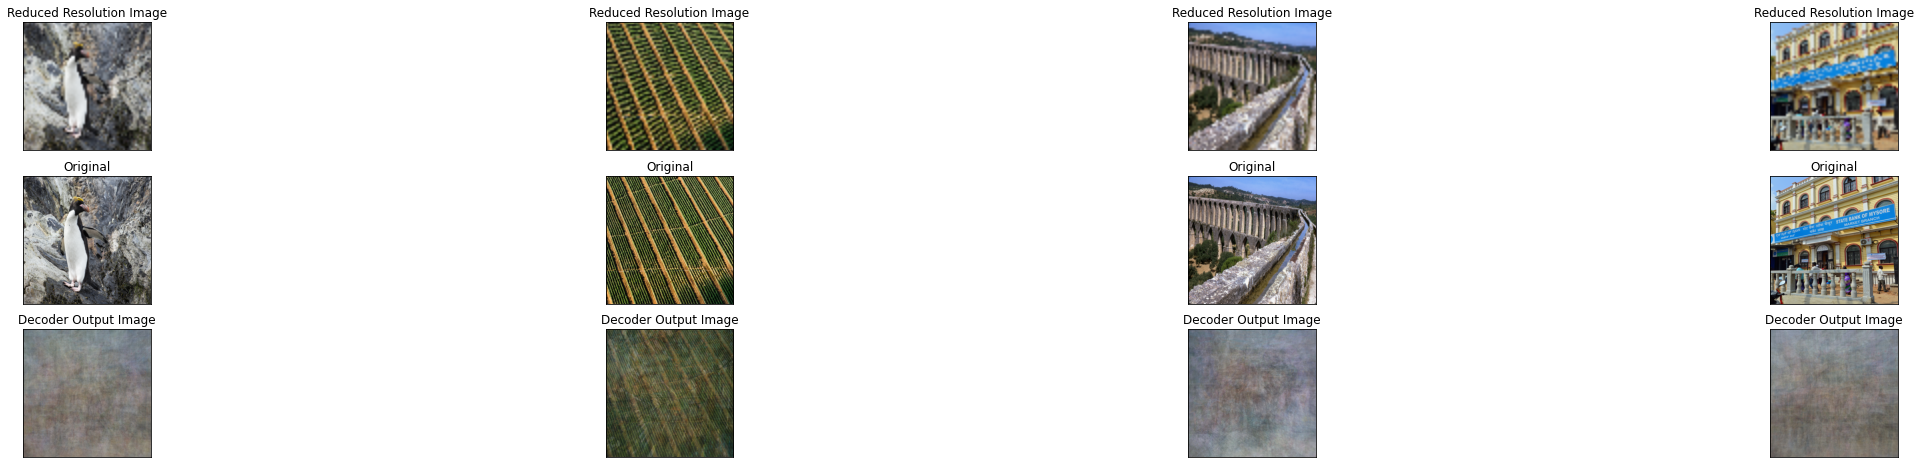

In [ ]:
for img1,img2 in val_dss.take(1):
  decoded_img=deep_autoencoder_model(img1,img2)
  r_img=tf.reshape(decoded_img,[4,384,384,3])
  c_img=img1
  b_img=img2
  c_img=tf.reshape(c_img,[4,384,384,3])
  b_img=tf.reshape(b_img,[4,384,384,3])
    
  n=4
  plt.figure(figsize=(40,8))
  for i in range(n):
    #Display the distorted
    bx=plt.subplot(3,n, i+1+n)
    plt.imshow(tf.squeeze(b_img[i]))
    plt.title('Original')
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

     #Display the original images
    ax= plt.subplot(3,n,i+1)
    plt.imshow(tf.squeeze(c_img[i]))
    plt.title('Reduced Resolution Image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #Display the output results
    rx=plt.subplot(3,n,i+5+n)
    plt.imshow(tf.squeeze(r_img[i]))
    plt.title('Decoder Output Image')
    rx.get_xaxis().set_visible(False)
    rx.get_yaxis().set_visible(False)

plt.show()